# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0))

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
## Use an object detector to detect the images from that feed to classifier
import os, struct
from scipy.misc import imresize

import numpy as np
import scipy.io as sio
import h5py
from matplotlib.pylab import *
import sklearn
from sklearn import datasets
from array import array as pyarray
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
%matplotlib inline
SEQ_LENGTH = 5



/home/kevin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/kevin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def get_dataset(filename,label=False,image=False):
    f = open(filename,'rb')
    if label:
        magic_nr,size = struct.unpack('>II',f.read(8))
        data =np.fromfile(f,dtype=np.int8)
    else:
        magic_nr,size,rows,cols = struct.unpack(">IIII",f.read(16))
        data = np.fromfile(f,dtype=np.uint8).reshape(size,rows,cols)
    f.close()
    return data

In [3]:
import random
def get_seq(img,lbl):
    idx = random.randrange(0,len(lbl))
    seq_len = random.randrange(0,SEQ_LENGTH)
    new_seq = np.full(6,10,np.int)
    new_seq[0] = seq_len+1
    new_image = img[idx]
    new_seq[1]=lbl[idx]
    for i in range(seq_len):
        idx = random.randrange(0,len(lbl))
        new_image = np.concatenate((new_image,img[idx]),axis=1)
        new_seq[i+2]=lbl[idx]
    new_image = imresize(new_image,(28,28))
    return new_image,new_seq


In [4]:
def get_dataset_seq(imgs,lbls):
    
    train_image_seq = []
    seq_labels = []
    for i in range(len(lbls)):
        train_image,train_label = get_seq(imgs,lbls)
        train_image_seq.append(train_image)
        seq_labels.append(train_label)
    train_images_seq = np.array(train_image_seq)
    train_images_seq = train_images_seq.reshape(-1, 28, 28, 1).astype(np.float32)
    return train_images_seq,np.array(seq_labels)


In [5]:
train_image_seq = []
seq_labels = []
train_images = get_dataset('train-images-idx3-ubyte',image=True)
train_labels = get_dataset('train-labels-idx1-ubyte',label=True)
test_images = get_dataset('t10k-images-idx3-ubyte',image=True)
test_labels = get_dataset('t10k-labels-idx1-ubyte',label=True)
train_images, train_labels = get_dataset_seq(train_images,train_labels)
test_images, test_labels = get_dataset_seq(test_images,test_labels)
test_images = test_images.astype(float32)

In [6]:
def accuracy(predictions, labels):
      return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

def pred_acc(predictions, labels):
    return (100.0 * np.sum(predictions == labels) / predictions.shape[1] / predictions.shape[0])

def check_predictions(original, labels, predictions):
    print('Accuracy: %.1f%%' % pred_acc(predictions, labels))
    for i, sample in enumerate(original):
        sample = sample.reshape(sample.shape[0], sample.shape[1],).astype(np.float32)
        plt.imshow(sample)
        plt.show()
        l_ele = labels[i]
        p_ele = predictions[i]
        print('Label %s - Prediction %s' % (l_ele[l_ele != 10], p_ele[p_ele != 10]))
        if (i == 10):
            break

In [7]:
import tensorflow as tf
IMAGE_SIZE = 28
NUM_CHANNELS = 1
NUM_LABELS = 11
N = 5

BATCH_SIZE = 64
PATCH_SIZE = 5
DEPTH_1 = 16
DEPTH_2 = 32
DEPTH_3 = 64

NODES = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
    tf_train_labels = tf.placeholder(tf.int64, shape=(BATCH_SIZE, N+1))
    tf_test_dataset = tf.constant(test_images)
  # Variables.
  # 5x5 Filter, depth 16 
    conv1_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, NUM_CHANNELS, DEPTH_1], stddev=0.1))
    conv1_biases = tf.Variable(tf.zeros([DEPTH_1]))

      # 5x5 Filter, depth 32
    conv2_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_1, DEPTH_2], stddev=0.1))
    conv2_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH_2]))

      # 5x5 Filter, depth 64
    conv3_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_2, DEPTH_3], stddev=0.1))
    conv3_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH_3]))

      # Linear 
    N1_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS],stddev=0.1))
    N1_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))

    N2_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
    N2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))

    N3_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
    N3_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))

    N4_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
    N4_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))

    N5_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
    N5_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))

    NL_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
    NL_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))

  # Model.
    def model(data):

        kernel1 = tf.nn.conv2d(data, conv1_weights, strides=[1, 1, 1, 1], padding='VALID')
        conv1 = tf.nn.relu(tf.nn.bias_add(kernel1, conv1_biases))
        pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        norm1 = tf.nn.local_response_normalization(pool1)

        kernel2 = tf.nn.conv2d(norm1, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
        conv2 = tf.nn.relu(tf.nn.bias_add(kernel2, conv2_biases))
        pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        norm2 = tf.nn.local_response_normalization(pool2)
        drop2 = tf.nn.dropout(norm2,keep_prob=.8)
        
        kernel3 = tf.nn.conv2d(drop2, conv3_weights, [1, 1, 1, 1], padding='VALID')
        conv3 = tf.nn.relu(tf.nn.bias_add(kernel3, conv3_biases))
        norm3 = tf.nn.local_response_normalization(conv3)
        pool = tf.nn.max_pool(norm3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        #pool = norm3

        pool_shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
        # Linear Extraction for each component
        feature_L = tf.nn.bias_add(tf.matmul(reshape, NL_weights), NL_biases)
        feature_1 = tf.nn.bias_add(tf.matmul(reshape, N1_weights), N1_biases)
        feature_2 = tf.nn.bias_add(tf.matmul(reshape, N2_weights), N2_biases)
        feature_3 = tf.nn.bias_add(tf.matmul(reshape, N3_weights), N3_biases)
        feature_4 = tf.nn.bias_add(tf.matmul(reshape, N4_weights), N4_biases)
        feature_5 = tf.nn.bias_add(tf.matmul(reshape, N5_weights), N5_biases)

        return feature_L, feature_1, feature_2, feature_3, feature_4, feature_5  
    logits_L, logits_1, logits_2, logits_3, logits_4, logits_5 = model(tf_train_dataset)
    lL = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_L, tf_train_labels[:,0]))
    l1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_1, tf_train_labels[:,1]))
    l2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_2, tf_train_labels[:,2]))
    l3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_3, tf_train_labels[:,3]))
    l4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_4, tf_train_labels[:,4]))
    l5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_5, tf_train_labels[:,5]))

    loss = lL+l1+l2+l3+l4+l5

      # Optimizer.
    optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)

      # Predictions for the training, validation, and test data.
    train_prediction = tf.pack([
                          tf.nn.softmax(model(tf_train_dataset)[0]),\
                          tf.nn.softmax(model(tf_train_dataset)[1]),\
                          tf.nn.softmax(model(tf_train_dataset)[2]),\
                          tf.nn.softmax(model(tf_train_dataset)[3]),\
                          tf.nn.softmax(model(tf_train_dataset)[4]),\
                          tf.nn.softmax(model(tf_train_dataset)[5])])
    test_prediction = tf.pack([
                          tf.nn.softmax(model(tf_test_dataset)[0]),\
                          tf.nn.softmax(model(tf_test_dataset)[1]),\
                          tf.nn.softmax(model(tf_test_dataset)[2]),\
                          tf.nn.softmax(model(tf_test_dataset)[3]),\
                          tf.nn.softmax(model(tf_test_dataset)[4]),\
                          tf.nn.softmax(model(tf_test_dataset)[5])])

    saver = tf.train.Saver()

    
NUM_STEPS = 10001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    #sp = saver.restore(session, "tmp/MNIST-CNN-sequence-L.ckpt")
    print('Model Restored')
    print('Initialized')
    for step in range(NUM_STEPS):
        offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
        batch_data = train_images[offset:(offset + BATCH_SIZE), :, :, :]
        batch_labels = train_labels[offset:(offset + BATCH_SIZE),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            
    sp = saver.save(session, "tmp/MNIST-CNN-sequence-L.ckpt")
    print('Model Saved')
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Tensor("strided_slice:0", shape=(64,), dtype=int64)
Model Restored
Initialized
Minibatch loss at step 0: 14.813530
Minibatch accuracy: 3.1%
Minibatch loss at step 500: 5.095520
Minibatch accuracy: 69.8%
Minibatch loss at step 1000: 3.142512
Minibatch accuracy: 84.1%
Minibatch loss at step 1500: 2.377807
Minibatch accuracy: 85.7%
Minibatch loss at step 2000: 1.702156
Minibatch accuracy: 92.4%
Minibatch loss at step 2500: 1.655605
Minibatch accuracy: 89.8%
Minibatch loss at step 3000: 1.538032
Minibatch accuracy: 91.4%
Minibatch loss at step 3500: 1.297106
Minibatch accuracy: 93.0%
Minibatch loss at step 4000: 1.187441
Minibatch accuracy: 93.0%
Minibatch loss at step 4500: 1.064278
Minibatch accuracy: 95.3%
Minibatch loss at step 5000: 0.971583
Minibatch accuracy: 95.3%
Minibatch loss at step 5500: 0.816800
Minibatch accuracy: 94.8%
Minibatch loss at step 6000: 1.221424
Minibatch accuracy: 93.5%
Minibatch loss at step 6500: 0.834372
Minibatch accuracy: 95.3%
Minibatch loss at step 7000: 

Tensor("pack_1:0", shape=(6, 10000, 11), dtype=float32)
Accuracy: 96.7%


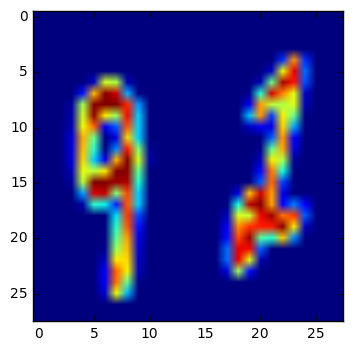

Label [2 9 2] - Prediction [2 9 2]


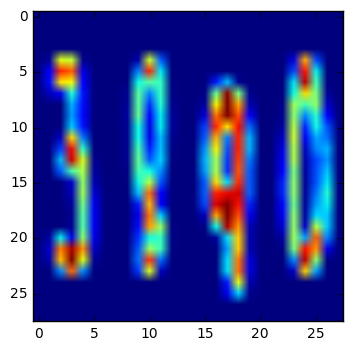

Label [4 3 8 9 0] - Prediction [4 3 8 9 0]


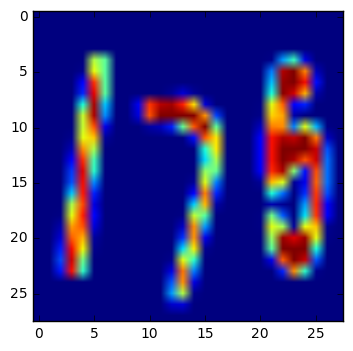

Label [3 1 7 5] - Prediction [3 1 7 5]


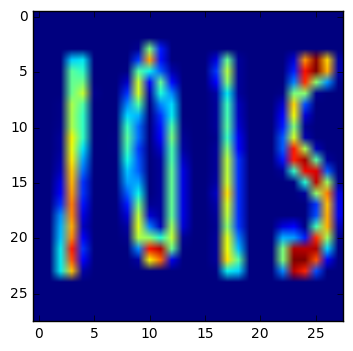

Label [4 1 0 1 5] - Prediction [4 1 0 1 5]


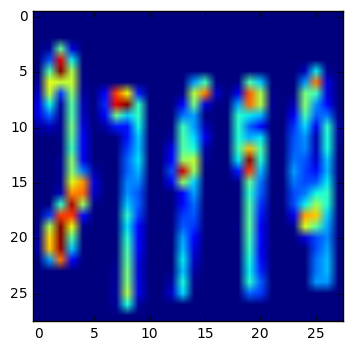

Label [5 2 7 9 9 9] - Prediction [5 2 7 9 9 8]


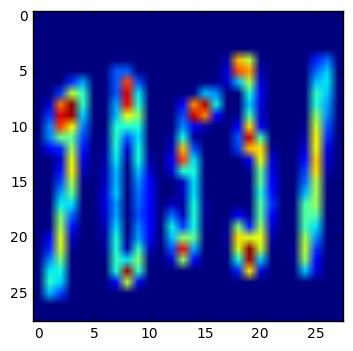

Label [5 7 0 5 3 1] - Prediction [5 7 0 5 3 1]


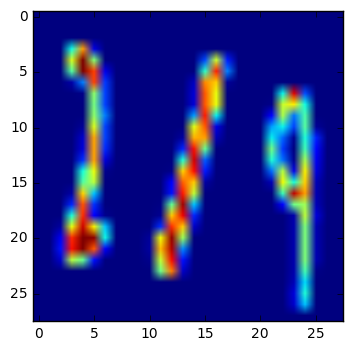

Label [3 2 1 9] - Prediction [3 2 1 9]


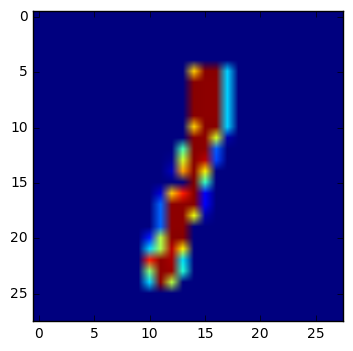

Label [1 1] - Prediction [1 1]


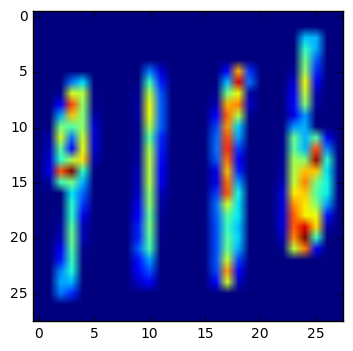

Label [4 9 1 8 6] - Prediction [4 9 1 1 6]


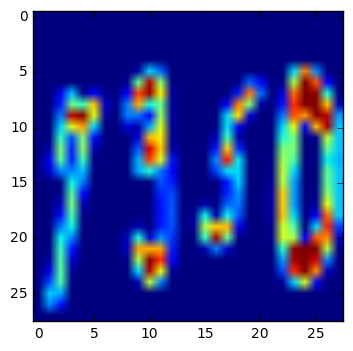

Label [4 7 3 5 0] - Prediction [4 7 3 5 0]


In [8]:

with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver()
    sp = saver.restore(sess, "tmp/MNIST-CNN-sequence-L.ckpt")
    print(test_prediction)
    predictions = tf.transpose(tf.argmax(test_prediction, 2))

    check_predictions(test_images[100:110],test_labels[100:110],predictions.eval()[100:110])

### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 
    For this problem I used a 3 layer conv net and treated each digit as a feature to try and predict as well as the length. I prepared the dataset by selecting at random sequences of up to 5 digits from the mnist dataset

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**
    My model is a 3 layer conv net, all with relu activations and the middle layer with dropout. The filter they all use is a 5x5 filter and the final depth of the net is 64. At the end of the 3 convolutions and pooling it is then using a fully connected layer for each of the labels. The layer has 64 nodes. 

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**

As shown in the prediction I generated a synthetic dataset which concatenated random sequences of up to 5 digits.

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
import h5py
import numpy as np
def get_labels(filename):
    f = h5py.File(filename)
    #use object with label name and bounding box data
    labels = {}
    labels['label'] = []
    labels['left'] = []
    labels['top'] = []
    labels['height'] = []
    labels['width'] = []
    def get_label(name, obj):
        values_for_digits=[]
        #check if only contains 1 value     
        values_for_digits.append(obj[0][0]) if obj.shape[0] == 1 else values_for_digits.append([f[obj[i][0]][0][0] for i in range(obj.shape[0])])
        labels[name].append(values_for_digits)        
          
    for item in f['/digitStruct/bbox']:
        f[item[0]].visititems(get_label)
    f.close()
    return labels

In [2]:
svnh_train_labels = get_labels('train/digitStruct.mat')
svnh_test_labels = get_labels('test/digitStruct.mat')

In [23]:
import cv2
import numpy as np
from scipy.misc import imresize
def get_images(directory_name,lbls,image_size,use_crops=False):
    images = []
    display_count=0
    for i in range(1,len(lbls['label'])+1):
        display_count+=1
        filename = directory_name + str(i)+'.png'
        if type(lbls['label'][i-1]) == np.float64 or len(lbls['label'][i-1])<6 :
            im = cv2.imread(filename)
            
            if use_crops:
                #print(type(lbls['label'][i-1]))
                #print(len(lbls['label'][i-1][0]))
                data = {}
                if type(lbls['label'][i-1][0])==np.float64:
                    #print('here')
                    #print(lbls['top'][i-1])
                    data['top'] = np.array(lbls['top'][i-1]).astype(np.int)
                    data['width'] = np.array(lbls['width'][i-1]).astype(np.int)
                    data['height'] = np.array(lbls['height'][i-1]).astype(np.int)
                    data['left'] = np.array(lbls['left'][i-1]).astype(np.int)
                    im = generate_sequence_from_crops(im,data,image_size)
                elif len(lbls['label'][i-1][0])==6:
                    im = 'Not Valid'
                    
                else:
                    
                    data['top'] = np.array(lbls['top'][i-1][0]).astype(np.int)
                    data['width'] = np.array(lbls['width'][i-1][0]).astype(np.int)
                    data['height'] = np.array(lbls['height'][i-1][0]).astype(np.int)
                    data['left'] = np.array(lbls['left'][i-1][0]).astype(np.int)
                    im = generate_sequence_from_crops(im,data,image_size)
                
            else:
                
                im = cv2.resize(im,(image_size)).astype(np.float32)
            if(type(im)!=str):
                im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
                im = im.reshape(image_size[0],image_size[1],1)
                images.append(im) 
        
        if display_count %10000 == 0:
            print(display_count,' images read')
    print(directory_name,'complete!')
    return np.array(images).astype(np.float32)

In [13]:
def generate_sequence_from_crops(image, crop_data,image_size):
    new_img = image[ crop_data['top'][0]: crop_data['top'][0]+crop_data['height'][0],
                           max(crop_data['left'][0],0):crop_data['left'][0]+crop_data['width'][0] ]
    new_img = imresize(new_img,image_size)
    for i in range(1,len(crop_data['top'])):
        cropped_dig = image[ crop_data['top'][i]: crop_data['top'][i]+crop_data['height'][i],
                           crop_data['left'][i]:crop_data['left'][i]+crop_data['width'][i] ]
        cropped_dig = imresize(cropped_dig,image_size)
        new_img = np.concatenate([new_img,cropped_dig],axis=1)
    new_img = imresize(new_img,(image_size))
    return new_img
        

In [34]:
svnh_train_images = get_images('train/',svnh_train_labels,(32,32),use_crops=True)
svnh_test_images = get_images('test/',svnh_test_labels,(32,32),use_crops=True)

10000  images read
20000  images read
30000  images read
train/ complete!
10000  images read
test/ complete!


In [35]:

def process_labels(lbls):
    processed_labels = []
    for lbl in lbls:
        lbl = lbl[0]
        new_lbl = np.full(6,10,np.float32)
        if type(lbl) == np.float64:
            
            new_lbl[0] = 1
            new_lbl[1] = lbl
            processed_labels.append(new_lbl)
        #else:    
        elif len(lbl)<6:
           
            
            new_lbl[0] = len(lbl)
            if len(lbl)==6:
                print(lbl)
            for i in range(len(lbl)):
                new_lbl[i+1] = lbl[i]
            processed_labels.append(new_lbl)
    return np.array(processed_labels)

In [36]:
svnh_processed_train_labels = process_labels(svnh_train_labels['label'])
svnh_processed_test_labels = process_labels(svnh_test_labels['label'])

In [37]:
def accuracy(predictions, labels):
      return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

def pred_acc(predictions, labels):
    return (100.0 * np.sum(predictions == labels) / predictions.shape[1] / predictions.shape[0])

def check_predictions(original, labels, predictions):
    print('Accuracy: %.1f%%' % pred_acc(predictions, labels))
    for i, sample in enumerate(original):
        sample = sample.reshape(sample.shape[0], sample.shape[1],).astype(np.float32)
        plt.imshow(sample)
        plt.show()
        l_ele = labels[i]
        p_ele = predictions[i]
        print('Label %s - Prediction %s' % (l_ele[l_ele != 10], p_ele[p_ele != 10]))
        if (i == 10):
            break

In [ ]:
import tensorflow as tf
def conv2d_batch_relu(bottom,phase,scope):
    with tf.variable_scope(scope):
        conv = tf.nn.conv

In [39]:
import tensorflow as tf
import time
IMAGE_SIZE = 32
NUM_CHANNELS = 1
NUM_LABELS = 11
N = 5
EPOCHS = 150
BATCH_SIZE = 64

NODES = 4096

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
    tf_train_labels = tf.placeholder(tf.int64, shape=(BATCH_SIZE, N+1))
    tf_test_dataset = tf.constant(svnh_test_images)
    #conv3-64
    conv1_1 = tf.Variable(tf.truncated_normal([3,3,1,64],stddev=0.1))
    conv1_1_biases = tf.Variable(tf.zeros([64]))
    #conv3-64
    conv1_2 = tf.Variable(tf.truncated_normal([3,3,64,64],stddev=0.1))
    conv1_2_biases = tf.Variable(tf.zeros([64]))
    #maxpool
    #conv3-128
    conv2_1 = tf.Variable(tf.truncated_normal([3,3,64,128],stddev=0.1))
    conv2_1_biases = tf.Variable(tf.zeros([128]))
    #conv3-128
    conv2_2 = tf.Variable(tf.truncated_normal([3,3,128,128],stddev=0.1))
    conv2_2_biases = tf.Variable(tf.zeros([128]))
    #maxpool
    #conv3-256
    conv3_1 = tf.Variable(tf.truncated_normal([3,3,128,256],stddev=0.1))
    conv3_1_biases = tf.Variable(tf.zeros([256]))
    #conv3-256
    conv3_2 = tf.Variable(tf.truncated_normal([3,3,256,256],stddev=0.1))
    conv3_2_biases = tf.Variable(tf.zeros([256]))
    #conv3-256
    conv3_3 = tf.Variable(tf.truncated_normal([3,3,256,256],stddev=0.1))
    conv3_3_biases = tf.Variable(tf.zeros([256]))
    #maxpool
    #conv3-512
    conv4_1 = tf.Variable(tf.truncated_normal([3,3,256,512],stddev=0.1))
    conv4_1_biases = tf.Variable(tf.zeros([512]))
    #conv3-512
    conv4_2 = tf.Variable(tf.truncated_normal([3,3,512,512],stddev=0.1))
    conv4_2_biases = tf.Variable(tf.zeros([512]))
    #conv3-512
    conv4_3 = tf.Variable(tf.truncated_normal([3,3,512,512],stddev=0.1))
    conv4_3_biases = tf.Variable(tf.zeros([512]))
    #maxpool
    #conv3-512
    conv5_1 = tf.Variable(tf.truncated_normal([3,3,512,512],stddev=0.1))
    conv5_1_biases = tf.Variable(tf.zeros([512]))
    #conv3-512
    conv5_2 = tf.Variable(tf.truncated_normal([3,3,512,512],stddev=0.1))
    conv5_2_biases = tf.Variable(tf.zeros([512]))
    #conv3-512
    conv5_3 = tf.Variable(tf.truncated_normal([3,3,512,512],stddev=0.1))
    conv5_3_biases = tf.Variable(tf.zeros([512]))
        
    #maxpool
    #FC-4096
    fc_6_weights = tf.Variable(tf.truncated_normal([512,4608],stddev=0.1))
    fc_6_bias = tf.Variable(tf.constant(1.0,shape=[4608]))
    #FC-4096
    fc_7_weights = tf.Variable(tf.truncated_normal([4608,4096],stddev=0.1))
    fc_7_bias = tf.Variable(tf.constant(1.0,shape=[4096]))
    #FC-1000
    #SOFT-MAX
        # Linear 
    N1_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS],stddev=0.1))
    N1_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))

    N2_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
    N2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))

    N3_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
    N3_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))

    N4_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
    N4_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))

    N5_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
    N5_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))

    NL_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
    NL_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
    def model(data):
        
        kernel1_1 = tf.nn.conv2d(data,conv1_1,strides=[1,1,1,1], padding='SAME')
        conv1_1_layer = tf.nn.relu(tf.nn.bias_add(kernel1_1,conv1_1_biases))
        kernel1_2 = tf.nn.conv2d(conv1_1_layer,conv1_2,strides=[1,1,1,1], padding='SAME')
        conv1_2_layer = tf.nn.relu(tf.nn.bias_add(kernel1_2,conv1_2_biases))
        pool1 = tf.nn.max_pool(conv1_2_layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

        kernel2_1 = tf.nn.conv2d(pool1,conv2_1,strides=[1,1,1,1], padding='SAME')
        conv2_1_layer = tf.nn.relu(tf.nn.bias_add(kernel2_1,conv2_1_biases))
        kernel2_2 = tf.nn.conv2d(conv2_1_layer,conv2_2,strides=[1,1,1,1], padding='SAME')
        conv2_2_layer = tf.nn.relu(tf.nn.bias_add(kernel2_2,conv2_2_biases))
        pool2 = tf.nn.max_pool(conv2_2_layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
        
        kernel3_1 = tf.nn.conv2d(pool2,conv3_1,strides=[1,1,1,1], padding='SAME')
        conv3_1_layer = tf.nn.relu(tf.nn.bias_add(kernel3_1,conv3_1_biases))
        kernel3_2 = tf.nn.conv2d(conv3_1_layer,conv3_2,strides=[1,1,1,1], padding='SAME')
        conv3_2_layer = tf.nn.relu(tf.nn.bias_add(kernel3_2,conv3_2_biases))
        kernel3_3 = tf.nn.conv2d(conv3_2_layer,conv3_3,strides=[1,1,1,1], padding='SAME')
        conv3_3_layer = tf.nn.relu(tf.nn.bias_add(kernel3_3,conv3_3_biases))
        pool3 = tf.nn.max_pool(conv3_3_layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
        
        kernel4_1 = tf.nn.conv2d(pool3,conv4_1,strides=[1,1,1,1], padding='SAME')
        conv4_1_layer = tf.nn.relu(tf.nn.bias_add(kernel4_1,conv4_1_biases))
        
        kernel4_2 = tf.nn.conv2d(conv4_1_layer,conv4_2,strides=[1,1,1,1], padding='SAME')
        conv4_2_layer = tf.nn.relu(tf.nn.bias_add(kernel4_2,conv4_2_biases))
        
        kernel4_3 = tf.nn.conv2d(conv4_2_layer,conv4_3,strides=[1,1,1,1], padding='SAME')
        conv4_3_layer = tf.nn.relu(tf.nn.bias_add(kernel4_3,conv4_3_biases))
        
        pool4 = tf.nn.max_pool(conv4_3_layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
        kernel5_1 = tf.nn.conv2d(pool4,conv5_1,strides=[1,1,1,1], padding='SAME')
        conv5_1_layer = tf.nn.relu(tf.nn.bias_add(kernel5_1,conv5_1_biases))
        kernel5_2 = tf.nn.conv2d(conv5_1_layer,conv5_2,strides=[1,1,1,1], padding='SAME')
        conv5_2_layer = tf.nn.relu(tf.nn.bias_add(kernel5_2,conv5_2_biases))
        kernel5_3 = tf.nn.conv2d(conv5_2_layer,conv5_3,strides=[1,1,1,1], padding='SAME')
        conv5_3_layer = tf.nn.relu(tf.nn.bias_add(kernel5_3,conv5_3_biases))
        pool5 = tf.nn.max_pool(conv5_3_layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

        pool_shape = pool5.get_shape().as_list()
        reshape = tf.reshape(pool5, [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
        fc_6 = tf.nn.bias_add(tf.matmul(reshape,fc_6_weights),fc_6_bias)
        fc_6 = tf.nn.relu(fc_6)
        fc_7 = tf.nn.bias_add(tf.matmul(fc_6,fc_7_weights),fc_7_bias)
        fc_7 = tf.nn.relu(fc_7)
        # Linear Extraction for each component
        feature_L = tf.nn.bias_add(tf.matmul(fc_7, NL_weights), NL_biases)
        feature_1 = tf.nn.bias_add(tf.matmul(fc_7, N1_weights), N1_biases)
        feature_2 = tf.nn.bias_add(tf.matmul(fc_7, N2_weights), N2_biases)
        feature_3 = tf.nn.bias_add(tf.matmul(fc_7, N3_weights), N3_biases)
        feature_4 = tf.nn.bias_add(tf.matmul(fc_7, N4_weights), N4_biases)
        feature_5 = tf.nn.bias_add(tf.matmul(fc_7, N5_weights), N5_biases)

        return feature_L, feature_1, feature_2, feature_3, feature_4, feature_5 
    logits_L, logits_1, logits_2, logits_3, logits_4, logits_5 = model(tf_train_dataset)
    lL = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_L, tf_train_labels[:,0]))
    l1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_1, tf_train_labels[:,1]))
    l2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_2, tf_train_labels[:,2]))
    l3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_3, tf_train_labels[:,3]))
    l4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_4, tf_train_labels[:,4]))
    l5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_5, tf_train_labels[:,5]))

    loss = lL+l1+l2+l3+l4+l5

      # Optimizer.
    optimizer = tf.train.AdamOptimizer(0.0001).minimize(loss)

      # Predictions for the training, validation, and test data.
    train_prediction = tf.pack([
                          tf.nn.softmax(model(tf_train_dataset)[0]),\
                          tf.nn.softmax(model(tf_train_dataset)[1]),\
                          tf.nn.softmax(model(tf_train_dataset)[2]),\
                          tf.nn.softmax(model(tf_train_dataset)[3]),\
                          tf.nn.softmax(model(tf_train_dataset)[4]),\
                          tf.nn.softmax(model(tf_train_dataset)[5])])
    test_prediction = tf.pack([
                          tf.nn.softmax(model(tf_test_dataset)[0]),\
                          tf.nn.softmax(model(tf_test_dataset)[1]),\
                          tf.nn.softmax(model(tf_test_dataset)[2]),\
                          tf.nn.softmax(model(tf_test_dataset)[3]),\
                          tf.nn.softmax(model(tf_test_dataset)[4]),\
                          tf.nn.softmax(model(tf_test_dataset)[5])])
    saver = tf.train.Saver()

    
NUM_STEPS = (int(svnh_processed_train_labels.shape[0]/BATCH_SIZE))*EPOCHS
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Model Restored')
    print('Initialized')
    start_time = time.time()
    epoch_time = time.time()
    epoch = 1
    for step in range(NUM_STEPS):
        offset = (step * BATCH_SIZE) % (svnh_processed_train_labels.shape[0] - BATCH_SIZE)
        batch_data = svnh_train_images[offset:(offset + BATCH_SIZE), :, :, :]
        batch_labels = svnh_processed_train_labels[offset:(offset + BATCH_SIZE),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if  ((step)%int(svnh_processed_train_labels.shape[0]/BATCH_SIZE)   == 0):
            
            print('Epoch:',epoch )
            epoch+=1
            print('Epoch loss:', l)
            print('Epoch accuracy:',accuracy(predictions, batch_labels))
            print('Epoch Time',(time.time()-epoch_time)) if epoch != 2 else None
            epoch_time = time.time()
    sp = saver.save(session, "tmp/MNIST-SVNH-sequence-L.ckpt")
    print('Model Saved')
    #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), svnh_processed_test_labels))
    print('Total time:',(time.time()-start_time-time.time))            
            

Model Restored
Initialized
Epoch: 1
Epoch loss: 8.41199e+08
Epoch accuracy: 6.77083333333
Epoch: 2
Epoch loss: 1.37703e+06
Epoch accuracy: 65.1041666667
Epoch Time 30.359803915023804
Epoch: 3
Epoch loss: 553028.0
Epoch accuracy: 67.96875
Epoch Time 30.256975412368774
Epoch: 4
Epoch loss: 292184.0
Epoch accuracy: 68.4895833333
Epoch Time 30.25834369659424
Epoch: 5
Epoch loss: 176227.0
Epoch accuracy: 69.2708333333
Epoch Time 30.247568607330322
Epoch: 6
Epoch loss: 141237.0
Epoch accuracy: 70.8333333333
Epoch Time 30.33228039741516
Epoch: 7
Epoch loss: 87620.1
Epoch accuracy: 71.6145833333
Epoch Time 30.310625076293945
Epoch: 8
Epoch loss: 55300.6
Epoch accuracy: 73.1770833333
Epoch Time 30.331318378448486
Epoch: 9
Epoch loss: 41208.8
Epoch accuracy: 69.0104166667
Epoch Time 30.30691695213318
Epoch: 10
Epoch loss: 33448.4
Epoch accuracy: 71.875
Epoch Time 30.311218976974487
Epoch: 11
Epoch loss: 21889.8
Epoch accuracy: 70.8333333333
Epoch Time 30.33330726623535
Epoch: 12
Epoch loss: 1877

TypeError: unsupported operand type(s) for -: 'float' and 'builtin_function_or_method'

In [10]:
import tensorflow as tf
import tensorflow as tf
import time
IMAGE_SIZE = 72
NUM_CHANNELS = 3
NUM_LABELS = 11
N = 5
EPOCHS = 15
BATCH_SIZE = 64
PATCH_SIZE = 3

NODES = 4096

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
    tf_train_labels = tf.placeholder(tf.int64, shape=(BATCH_SIZE, N+1))
    tf_test_dataset = tf.constant(svnh_test_images)
    #conv3-64
    conv1_1 = tf.Variable(tf.truncated_normal([3,3,3,64],stddev=0.1))
    conv1_1_biases = tf.Variable(tf.zeros([64]))
    #conv3-64
    conv1_2 = tf.Variable(tf.truncated_normal([3,3,64,64],stddev=0.1))
    conv1_2_biases = tf.Variable(tf.zeros([64]))
    #maxpool
    #conv3-128
    conv2_1 = tf.Variable(tf.truncated_normal([3,3,64,128],stddev=0.1))
    conv2_1_biases = tf.Variable(tf.zeros([128]))
    #conv3-128
    conv2_2 = tf.Variable(tf.truncated_normal([3,3,128,128],stddev=0.1))
    conv2_2_biases = tf.Variable(tf.zeros([128]))
    #maxpool
    #conv3-256
    conv3_1 = tf.Variable(tf.truncated_normal([3,3,128,256],stddev=0.1))
    conv3_1_biases = tf.Variable(tf.zeros([256]))
    #conv3-256
    conv3_2 = tf.Variable(tf.truncated_normal([3,3,256,256],stddev=0.1))
    conv3_2_biases = tf.Variable(tf.zeros([256]))
    #conv3-256
    conv3_3 = tf.Variable(tf.truncated_normal([3,3,256,256],stddev=0.1))
    conv3_3_biases = tf.Variable(tf.zeros([256]))
    #maxpool
    #conv3-512
    conv4_1 = tf.Variable(tf.truncated_normal([3,3,256,512],stddev=0.1))
    conv4_1_biases = tf.Variable(tf.zeros([512]))
    #conv3-512
    conv4_2 = tf.Variable(tf.truncated_normal([3,3,512,512],stddev=0.1))
    conv4_2_biases = tf.Variable(tf.zeros([512]))
    #conv3-512
    conv4_3 = tf.Variable(tf.truncated_normal([3,3,512,512],stddev=0.1))
    conv4_3_biases = tf.Variable(tf.zeros([512]))
    #maxpool
    #conv3-512
    conv5_1 = tf.Variable(tf.truncated_normal([3,3,512,512],stddev=0.1))
    conv5_1_biases = tf.Variable(tf.zeros([512]))
    #conv3-512
    conv5_2 = tf.Variable(tf.truncated_normal([3,3,512,512],stddev=0.1))
    conv5_2_biases = tf.Variable(tf.zeros([512]))
    #conv3-512
    conv5_3 = tf.Variable(tf.truncated_normal([3,3,512,512],stddev=0.1))
    conv5_3_biases = tf.Variable(tf.zeros([512]))
        
    #maxpool
    #FC-4096
    fc_6_weights = tf.Variable(tf.truncated_normal([4608,4608],stddev=0.1))
    fc_6_bias = tf.Variable(tf.constant(1.0,shape=[4608]))
    #FC-4096
    fc_7_weights = tf.Variable(tf.truncated_normal([4608,4096],stddev=0.1))
    fc_7_bias = tf.Variable(tf.constant(1.0,shape=[4096]))
    #FC-1000
    #SOFT-MAX
        # Linear 
    N1_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS],stddev=0.1))
    N1_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))

    N2_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
    N2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))

    N3_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
    N3_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))

    N4_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
    N4_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))

    N5_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
    N5_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))

    NL_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
    NL_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
    def model(data):
        
        kernel1_1 = tf.nn.conv2d(data,conv1_1,strides=[1,1,1,1], padding='SAME')
        conv1_1_layer = tf.nn.relu(tf.nn.bias_add(kernel1_1,conv1_1_biases))
        kernel1_2 = tf.nn.conv2d(conv1_1_layer,conv1_2,strides=[1,1,1,1], padding='SAME')
        conv1_2_layer = tf.nn.relu(tf.nn.bias_add(kernel1_2,conv1_2_biases))
        pool1 = tf.nn.max_pool(conv1_2_layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

        kernel2_1 = tf.nn.conv2d(pool1,conv2_1,strides=[1,1,1,1], padding='SAME')
        conv2_1_layer = tf.nn.relu(tf.nn.bias_add(kernel2_1,conv2_1_biases))
        kernel2_2 = tf.nn.conv2d(conv2_1_layer,conv2_2,strides=[1,1,1,1], padding='SAME')
        conv2_2_layer = tf.nn.relu(tf.nn.bias_add(kernel2_2,conv2_2_biases))
        pool2 = tf.nn.max_pool(conv2_2_layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
        
        kernel3_1 = tf.nn.conv2d(pool2,conv3_1,strides=[1,1,1,1], padding='SAME')
        conv3_1_layer = tf.nn.relu(tf.nn.bias_add(kernel3_1,conv3_1_biases))
        kernel3_2 = tf.nn.conv2d(conv3_1_layer,conv3_2,strides=[1,1,1,1], padding='SAME')
        conv3_2_layer = tf.nn.relu(tf.nn.bias_add(kernel3_2,conv3_2_biases))
        kernel3_3 = tf.nn.conv2d(conv3_2_layer,conv3_3,strides=[1,1,1,1], padding='SAME')
        conv3_3_layer = tf.nn.relu(tf.nn.bias_add(kernel3_3,conv3_3_biases))
        pool3 = tf.nn.max_pool(conv3_3_layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
        
        kernel4_1 = tf.nn.conv2d(pool3,conv4_1,strides=[1,1,1,1], padding='SAME')
        conv4_1_layer = tf.nn.relu(tf.nn.bias_add(kernel4_1,conv4_1_biases))
        
        kernel4_2 = tf.nn.conv2d(conv4_1_layer,conv4_2,strides=[1,1,1,1], padding='SAME')
        conv4_2_layer = tf.nn.relu(tf.nn.bias_add(kernel4_2,conv4_2_biases))
        
        kernel4_3 = tf.nn.conv2d(conv4_2_layer,conv4_3,strides=[1,1,1,1], padding='SAME')
        conv4_3_layer = tf.nn.relu(tf.nn.bias_add(kernel4_3,conv4_3_biases))
        
        pool4 = tf.nn.max_pool(conv4_3_layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
        kernel5_1 = tf.nn.conv2d(pool4,conv5_1,strides=[1,1,1,1], padding='SAME')
        conv5_1_layer = tf.nn.relu(tf.nn.bias_add(kernel5_1,conv5_1_biases))
        kernel5_2 = tf.nn.conv2d(conv5_1_layer,conv5_2,strides=[1,1,1,1], padding='SAME')
        conv5_2_layer = tf.nn.relu(tf.nn.bias_add(kernel5_2,conv5_2_biases))
        kernel5_3 = tf.nn.conv2d(conv5_2_layer,conv5_3,strides=[1,1,1,1], padding='SAME')
        conv5_3_layer = tf.nn.relu(tf.nn.bias_add(kernel5_3,conv5_3_biases))
        pool5 = tf.nn.max_pool(conv5_3_layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

        pool_shape = pool5.get_shape().as_list()
        reshape = tf.reshape(pool5, [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
        fc_6 = tf.nn.bias_add(tf.matmul(reshape,fc_6_weights),fc_6_bias)
        fc_6 = tf.nn.relu(fc_6)
        fc_7 = tf.nn.bias_add(tf.matmul(fc_6,fc_7_weights),fc_7_bias)
        fc_7 = tf.nn.relu(fc_7)
        # Linear Extraction for each component
        feature_L = tf.nn.bias_add(tf.matmul(fc_7, NL_weights), NL_biases)
        feature_1 = tf.nn.bias_add(tf.matmul(fc_7, N1_weights), N1_biases)
        feature_2 = tf.nn.bias_add(tf.matmul(fc_7, N2_weights), N2_biases)
        feature_3 = tf.nn.bias_add(tf.matmul(fc_7, N3_weights), N3_biases)
        feature_4 = tf.nn.bias_add(tf.matmul(fc_7, N4_weights), N4_biases)
        feature_5 = tf.nn.bias_add(tf.matmul(fc_7, N5_weights), N5_biases)

        return feature_L, feature_1, feature_2, feature_3, feature_4, feature_5 
    logits_L, logits_1, logits_2, logits_3, logits_4, logits_5 = model(tf_train_dataset)
    lL = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_L, tf_train_labels[:,0]))
    l1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_1, tf_train_labels[:,1]))
    l2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_2, tf_train_labels[:,2]))
    l3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_3, tf_train_labels[:,3]))
    l4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_4, tf_train_labels[:,4]))
    l5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_5, tf_train_labels[:,5]))

    loss = lL+l1+l2+l3+l4+l5

      # Optimizer.
    optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)

      # Predictions for the training, validation, and test data.
    train_prediction = tf.pack([
                          tf.nn.softmax(model(tf_train_dataset)[0]),\
                          tf.nn.softmax(model(tf_train_dataset)[1]),\
                          tf.nn.softmax(model(tf_train_dataset)[2]),\
                          tf.nn.softmax(model(tf_train_dataset)[3]),\
                          tf.nn.softmax(model(tf_train_dataset)[4]),\
                          tf.nn.softmax(model(tf_train_dataset)[5])])
    test_prediction = tf.pack([
                          tf.nn.softmax(model(tf_test_dataset)[0]),\
                          tf.nn.softmax(model(tf_test_dataset)[1]),\
                          tf.nn.softmax(model(tf_test_dataset)[2]),\
                          tf.nn.softmax(model(tf_test_dataset)[3]),\
                          tf.nn.softmax(model(tf_test_dataset)[4]),\
                          tf.nn.softmax(model(tf_test_dataset)[5])])
with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver()
    sp = saver.restore(sess, "tmp/MNIST-CNN-sequence-L.ckpt")
    print(test_prediction)
    predictions = tf.transpose(tf.argmax(test_prediction, 2))
#     print(predictions.eval().shape)
#     print('test_images',test_images[100:110])
#     print('test_labels',test_labels[100:110])
#     print('predictions.eval',predictions.eval()[100])
    check_predictions(svnh_test_images[100:110],svnh_processed_test_labels[100:110],predictions.eval()[100:110])

Tensor("pack_1:0", shape=(6, 13068, 11), dtype=float32)


ResourceExhaustedError: OOM when allocating tensor with shape[13068,72,72,64]
	 [[Node: Conv2D_91 = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/cpu:0"](Const, Variable/read)]]

Caused by op 'Conv2D_91', defined at:
  File "C:\Users\kcasado.CARSDIRECT\AppData\Local\Continuum\Anaconda3\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\kcasado.CARSDIRECT\AppData\Local\Continuum\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\kcasado.CARSDIRECT\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\kcasado.CARSDIRECT\AppData\Local\Continuum\Anaconda3\lib\site-packages\traitlets\config\application.py", line 653, in launch_instance
    app.start()
  File "C:\Users\kcasado.CARSDIRECT\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\kcasado.CARSDIRECT\AppData\Local\Continuum\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\kcasado.CARSDIRECT\AppData\Local\Continuum\Anaconda3\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Users\kcasado.CARSDIRECT\AppData\Local\Continuum\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\kcasado.CARSDIRECT\AppData\Local\Continuum\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\kcasado.CARSDIRECT\AppData\Local\Continuum\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\kcasado.CARSDIRECT\AppData\Local\Continuum\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\kcasado.CARSDIRECT\AppData\Local\Continuum\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\kcasado.CARSDIRECT\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\kcasado.CARSDIRECT\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\kcasado.CARSDIRECT\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\kcasado.CARSDIRECT\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\kcasado.CARSDIRECT\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\kcasado.CARSDIRECT\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\kcasado.CARSDIRECT\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\kcasado.CARSDIRECT\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-1d179a1ef905>", line 167, in <module>
    tf.nn.softmax(model(tf_test_dataset)[0]),\
  File "<ipython-input-10-1d179a1ef905>", line 92, in model
    kernel1_1 = tf.nn.conv2d(data,conv1_1,strides=[1,1,1,1], padding='SAME')
  File "C:\Users\kcasado.CARSDIRECT\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 396, in conv2d
    data_format=data_format, name=name)
  File "C:\Users\kcasado.CARSDIRECT\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "C:\Users\kcasado.CARSDIRECT\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\kcasado.CARSDIRECT\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[13068,72,72,64]
	 [[Node: Conv2D_91 = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/cpu:0"](Const, Variable/read)]]


### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.